Quantum State Preparation - QSP

In [25]:
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import svd
from math import sqrt
import numpy as np

In [39]:
# Função para preparar o estado de modo recursivo
def prepare_state(circuit, state, qubits):

    n = len(qubits)  # Número de qubits

    # Caso base: Se tivermos apenas dois qubits, usamos initialize.
    if n == 1:
        circuit.initialize(state, qubits)
        return

    # Divisão do espaço de Hilbert
    if n % 2 == 0:  # Número par de qubits
        k = n // 2
    else:  # Número ímpar de qubits
        k = n // 2  # Particiona em k e k+1 qubits

    dim1 = 2 ** k
    dim2 = 2 ** (n - k)
    state = state.reshape((dim1, dim2))  # Reshape para matriz retangular

    # Decomposição SVD para obter coeficientes de Schmidt e unitários
    U, singular_values, V_dag = svd(state)
    singular_values = singular_values / np.linalg.norm(singular_values)  # Normalizar

    # Prepara o estado no primeiro subespaço
    prepare_state(circuit, singular_values, qubits[:k])

    # Fase 2: Aplicar CNOT entre os dois subespaços
    for i in range(k):
        circuit.cx(qubits[i], qubits[i + k])

    # Fase 3: Aplicar o unitário no primeiro subespaço
    U_gate = UnitaryGate(U, label="U")
    circuit.append(U_gate, qubits[:k])

    # Fase 4: Aplicar o unitário no segundo subespaço
    V_gate = UnitaryGate(V_dag.T.conj(), label="V†")
    circuit.append(V_gate, qubits[k:])

In [40]:
# Função para preparar um estado quântico arbitrário
def prepare_arbitrary_state(n, state):

    if len(state) != 2**n:
        raise ValueError("O vetor do estado deve ter dimensão 2^n.")

    # Inicializar o circuito
    qc = QuantumCircuit(n)

    # Preparar o estado
    prepare_state(qc, state, list(range(n)))

    return qc

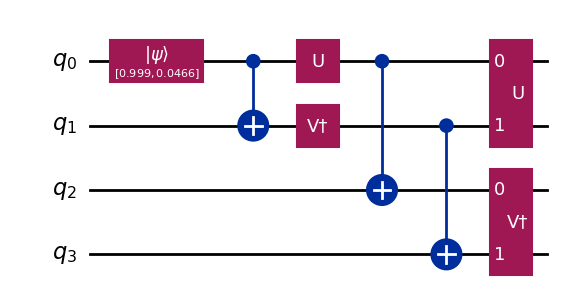

In [44]:
n_qubits = 4  # Teste com número ímpar
target_state = np.random.rand(2**n_qubits) + 1j * np.random.rand(2**n_qubits)  # Estado aleatório
target_state = target_state / np.linalg.norm(target_state)  # Normalizar

# Gerar o circuito
circuit = prepare_arbitrary_state(n_qubits, target_state)

# Exibir o circuito
circuit.draw('mpl')

In [45]:
# Simular o circuito
circuit.measure_all()

sampler = Sampler()

job = sampler.run([circuit])
result = job.result()
print(f" > Counts: {result[0].data.meas.get_counts()}")

 > Counts: {'0011': 103, '0100': 141, '0110': 43, '1000': 84, '0111': 78, '1011': 10, '1010': 123, '1101': 78, '1110': 87, '1111': 75, '1001': 51, '0001': 41, '0010': 46, '1100': 19, '0101': 31, '0000': 14}


Quantum Error Correction - QEC